# Import the dependencies

In [52]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from transformers import BertConfig
from transformers import RobertaTokenizerFast

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

sys.path.append("../../../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
sequence_len = 512
batch_size = 64

config = BertConfig(
    vocab_size=9,
    hidden_size=84,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=2
)

epochs = 30

# Load & Prepare the data

In [4]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_test = all_data["simple_terms"].tolist()
y_ri_test = all_data["RI_steps_num"].tolist()
y_lo_test = all_data["LO_steps_num"].tolist()

print(f"Count TESTING samples: {len(y_ri_test)}")

Count all terms: 4251

Count original terms: 4251

number samples: 4251
number samples only reducable: 4220

max RI steps count: 386
max LO steps count: 219
Count TESTING samples: 4220


In [5]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str_extended.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_train = all_data["simple_terms"].tolist()
y_ri_train = all_data["RI_steps_num"].tolist()
y_lo_train = all_data["LO_steps_num"].tolist()

print(f"Count TRAINING samples: {len(y_ri_train)}")

Count all terms: 44568

Count original terms: 44568

number samples: 44568
number samples only reducable: 42469

max RI steps count: 400
max LO steps count: 308
Count TRAINING samples: 42469


In [6]:
tokenizer = RobertaTokenizerFast.from_pretrained("../../transformers_to_lo_steps_prediciton/fine_models", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
x_train = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_train]
x_test = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_test]

In [8]:
def get_sample_weight(arr_1, arr_2):
    arr_1, arr_2 = np.array(arr_1), np.array(arr_2)
    abs_diff = np.abs(arr_1 - arr_2)
    abs_diff += 2
    return np.log(abs_diff) - 0.6


train_df = pd.DataFrame({
    "term_str": x_train, "diff_steps": np.array(y_lo_train) - np.array(y_ri_train),
    "lo_steps": y_lo_train, "ri_steps": y_ri_train,

    "sample_weights": get_sample_weight(y_ri_train, y_lo_train),
})
test_df = pd.DataFrame({
    "term_str": x_test, "diff_steps": np.array(y_lo_test) - np.array(y_ri_test),
    "lo_steps": y_lo_test, "ri_steps": y_ri_test,
    "sample_weights": get_sample_weight(y_ri_test, y_lo_test),
})

In [9]:
train_df.head(10)

,term_str,diff_steps,lo_steps,ri_steps,sample_weights
0,(y(y((x(y((x(y((x((x((xx)(y(((xx)(((yx)(x((yx)...,0,3,3,0.093147
1,((((((((y(y(yx)))(y(yx)))(((yx)(y(y((x(y(y(y(y...,-127,60,187,4.259812
2,(y(y(x(((((y(yx))(yx))((y(y(yx)))(y(y(xx)))))(...,-3,5,8,1.009438
3,(y(((x((xx)(x(x(xx)))))((x((x(yx))(xx)))((y(x(...,3,7,4,1.009438
4,(y((x(y((((x(x(y(y(x((xx)x))))))(x(((y(x((x((y...,0,2,2,0.093147
5,(y(y(((((((x(x(y(yx))))(x(x(y(x(x(y(yx))))))))...,-58,20,78,3.494345
6,((y(y(y((y(y((yx)x)))(x(((yx)(yx))((((y(yx))(y...,-5,3,8,1.345910
7,((y((((y(xx))(y((yx)(y(x(y(yx)))))))(y((y(x((y...,-20,11,31,2.491042
8,(y(((y(yx))(y(y(x((y(x((y(yx))(y(y(y(xx)))))))...,-6,10,16,1.479442
9,(y(y(y(((y((yx)x))(yx))(y(yx)))))),0,3,3,0.093147


In [10]:
test_df.head(10)

,term_str,diff_steps,lo_steps,ri_steps,sample_weights
0,(y(y(x(y((x(x(((x(y((xx)(x(y(yx))))))x)(y(y(xx...,0,0,0,0.093147
1,(((((((y(y(yx)))(y(y(xx))))((y(((y(y(yx)))(y(y...,-19,28,47,2.444522
2,(y(y(y(((x(yx))(yx))((x(y((yx)(y(x((((yx)(((xx...,-1,1,2,0.498612
3,(y((((((((y(y(x(xx))))(y(y(y(y(xx))))))(((y(y(...,-17,58,75,2.344439
4,(y(y(((xx)(y(y(y((x((((yx)(yx))(((yx)(yx))(((y...,0,8,8,0.093147
5,((((yx)(y((y(y((xx)(y((yx)x)))))((yx)(y((yx)(x...,-13,10,23,2.108050
6,(y(x(y(y(y(y(x((y(y((yx)(y(y(xx))))))(y(y(((y(...,-1,4,5,0.498612
7,(((((((((yx)(y(xx)))(yx))(((yx)(y(xx)))(yx)))(...,-7,84,91,1.597225
8,(y(((x(yx))(y((xx)((x((((x(xx))(xx))x)(y(y((xx...,0,1,1,0.093147
9,(y(y(y(y(y(x(y((y(y(xx)))x)))))))),0,1,1,0.093147


In [11]:
def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor(example["diff_steps"])
    sample_weights = tf.convert_to_tensor(example["sample_weights"])
    return tokenized_texts, labels, sample_weights


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [12]:
# train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1], tokenized_train_data[2])).batch(batch_size)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Define & Train the Model

In [13]:
# Define the model
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
# outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=64, activation="relu")(outputs)
outputs = Dense(units=1)(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [14]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error', ])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  130832      ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [15]:
model_structure = model.to_json()
with open("./fine_models/model_diff.json", 'w') as json_file:
    json_file.write(model_structure)

In [16]:
# Define the ModelCheckpoint callback
f1_callback = ModelCheckpoint(
    filepath='./fine_models/model_diff_best_MSE.h5',  # Specify the path to save the best model
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

step_callback = ModelCheckpoint('./fine_models/model_diff.h5', save_weights_only=True, save_freq=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/id_0", histogram_freq=1)

In [17]:
def draw_training_statistic(history_):
    plt.plot(range(1, epochs + 1), history_.history['loss'], label="MSE")
    plt.plot(range(1, epochs + 1), history_.history['val_loss'], label="val MSE")
    plt.xlabel("epochs")
    plt.title("total loss")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['mean_absolute_error'], label="MAE")
    plt.plot(range(1, epochs + 1), history_.history['val_mean_absolute_error'], label="val MAE")
    plt.xlabel("epochs")
    plt.title("total accuracy")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['root_mean_squared_error'], label="RMSE")
    plt.plot(range(1, epochs + 1), history_.history['val_root_mean_squared_error'], label="val RMSE")
    plt.xlabel("epochs")
    plt.title("total precision")
    plt.legend()
    plt.show()

Epoch 1/30
664/664 [==============================] - 156s 230ms/step - loss: 725.6447 - root_mean_squared_error: 26.9378 - mean_absolute_error: 10.3942 - val_loss: 414.1164 - val_root_mean_squared_error: 20.3499 - val_mean_absolute_error: 7.9367
Epoch 2/30
664/664 [==============================] - 152s 229ms/step - loss: 714.1246 - root_mean_squared_error: 26.7231 - mean_absolute_error: 10.2694 - val_loss: 446.6069 - val_root_mean_squared_error: 21.1331 - val_mean_absolute_error: 7.9926
Epoch 3/30
664/664 [==============================] - 152s 228ms/step - loss: 720.2751 - root_mean_squared_error: 26.8379 - mean_absolute_error: 10.3907 - val_loss: 421.5642 - val_root_mean_squared_error: 20.5320 - val_mean_absolute_error: 7.9021
Epoch 4/30
664/664 [==============================] - 153s 230ms/step - loss: 703.9398 - root_mean_squared_error: 26.5319 - mean_absolute_error: 10.1027 - val_loss: 415.2243 - val_root_mean_squared_error: 20.3771 - val_mean_absolute_error: 7.8732
Epoch 5/30
6

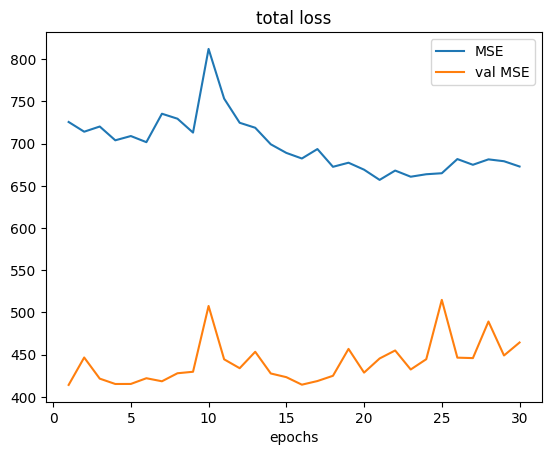

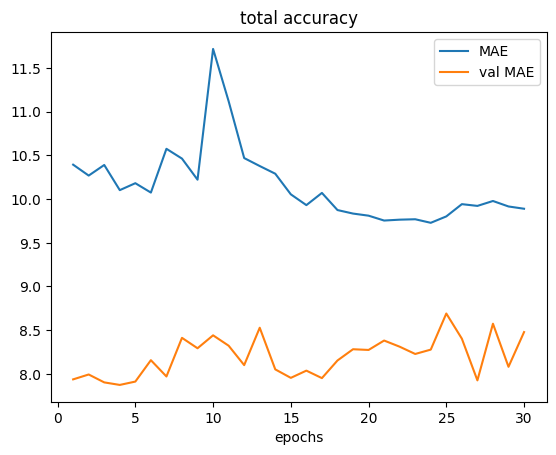

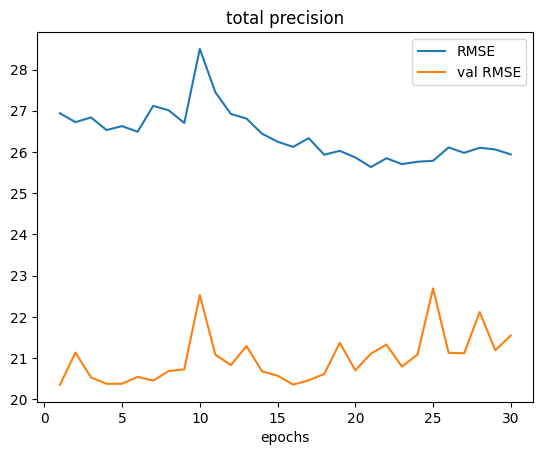

In [18]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 152s 229ms/step - loss: 667.9307 - root_mean_squared_error: 25.8444 - mean_absolute_error: 9.7723 - val_loss: 454.9436 - val_root_mean_squared_error: 21.3294 - val_mean_absolute_error: 8.1918
Epoch 2/30
664/664 [==============================] - 152s 228ms/step - loss: 672.1990 - root_mean_squared_error: 25.9268 - mean_absolute_error: 9.8191 - val_loss: 447.3563 - val_root_mean_squared_error: 21.1508 - val_mean_absolute_error: 8.0824
Epoch 3/30
664/664 [==============================] - 152s 229ms/step - loss: 675.9123 - root_mean_squared_error: 25.9983 - mean_absolute_error: 9.8694 - val_loss: 468.9101 - val_root_mean_squared_error: 21.6543 - val_mean_absolute_error: 8.3182
Epoch 4/30
664/664 [==============================] - 152s 229ms/step - loss: 667.4680 - root_mean_squared_error: 25.8354 - mean_absolute_error: 9.7799 - val_loss: 488.2807 - val_root_mean_squared_error: 22.0971 - val_mean_absolute_error: 8.5239
Epoch 5/30
664/6

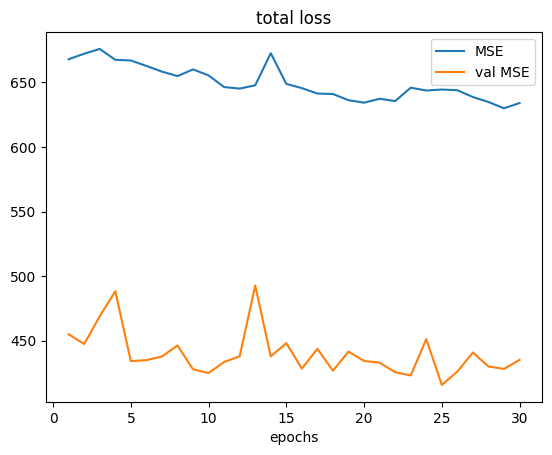

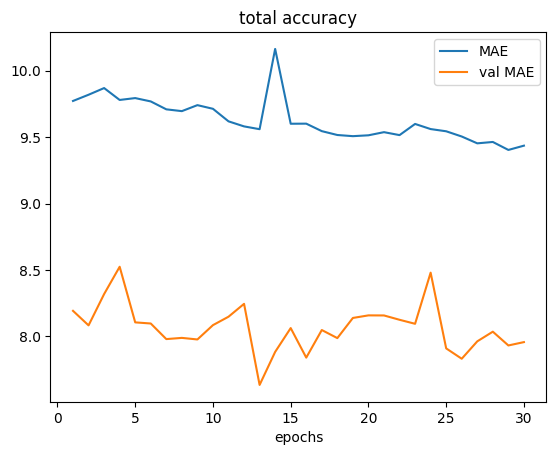

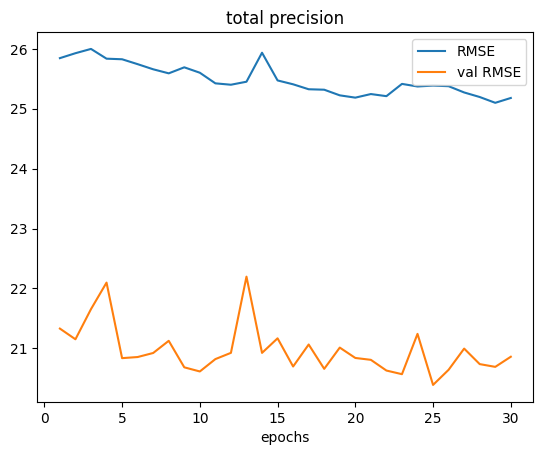

In [19]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 168s 253ms/step - loss: 632.2824 - root_mean_squared_error: 25.1452 - mean_absolute_error: 9.4377 - val_loss: 436.3931 - val_root_mean_squared_error: 20.8900 - val_mean_absolute_error: 8.1099
Epoch 2/30
664/664 [==============================] - 168s 253ms/step - loss: 636.6372 - root_mean_squared_error: 25.2317 - mean_absolute_error: 9.4759 - val_loss: 427.0437 - val_root_mean_squared_error: 20.6650 - val_mean_absolute_error: 7.9425
Epoch 3/30
664/664 [==============================] - 161s 242ms/step - loss: 635.4758 - root_mean_squared_error: 25.2086 - mean_absolute_error: 9.4825 - val_loss: 414.2344 - val_root_mean_squared_error: 20.3528 - val_mean_absolute_error: 7.8933
Epoch 4/30
664/664 [==============================] - 159s 239ms/step - loss: 630.7470 - root_mean_squared_error: 25.1147 - mean_absolute_error: 9.4229 - val_loss: 413.7729 - val_root_mean_squared_error: 20.3414 - val_mean_absolute_error: 7.7029
Epoch 5/30
664/6

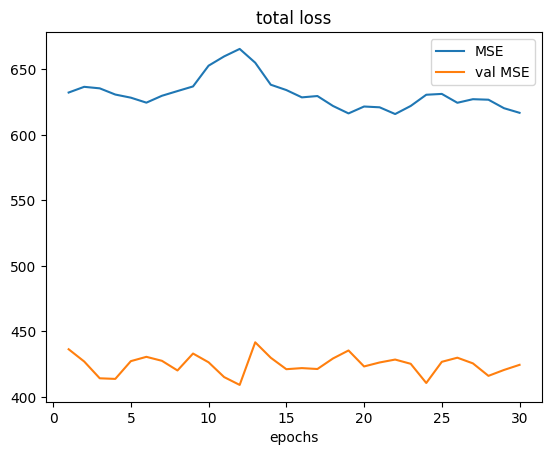

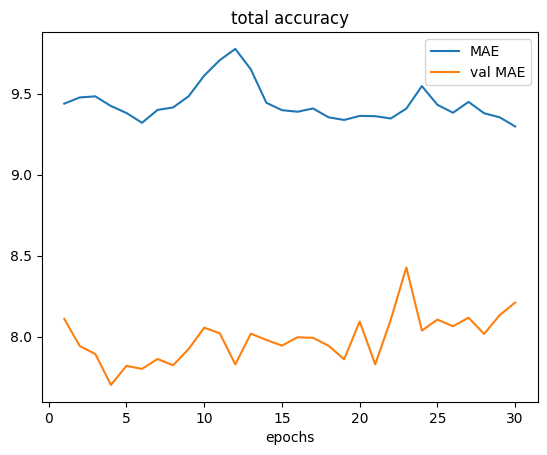

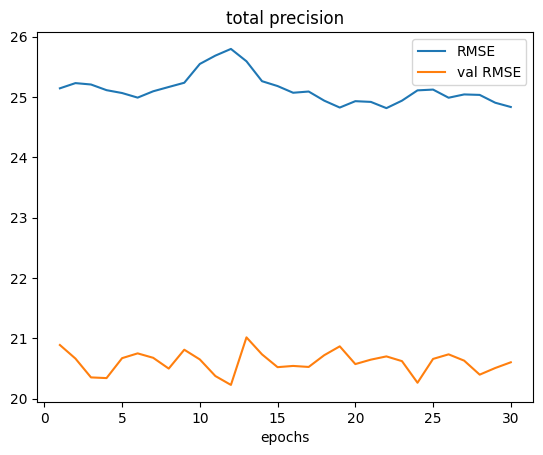

In [20]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

# TRAINED MODEL (after 90 epochs)

In [37]:
def draw_pred_scatter(y_pred, y_real, title_info="TEST"):
    plt.scatter(y_real, y_pred, s=3)
    min_val = min(min(y_pred), min(y_real))
    max_val = max(max(y_pred), min(y_real))
    plt.plot([min_val, min_val], [max_val, max_val], color='gray', linestyle='--')

    plt.xlabel("Real reduction step diff")
    plt.ylabel("Predicted step diff")
    plt.title(f"{title_info} Pred vs Real Reduction step diff")
    plt.show()

In [39]:
def draw_pred_lines_scatter(y_pred, y_real, title_info="TEST"):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    plt.plot(range(len(drawing_df["Real"])), drawing_df["Real"], label="Real", c=colors[1])
    plt.scatter(range(len(drawing_df["Pred"])), drawing_df["Pred"], label="Pred", s=3, c=colors[0])

    plt.xlabel("No")
    plt.ylabel("Step diff")
    plt.title(f"{title_info} Pred vs Real Step Diff")
    plt.legend()
    plt.show()

In [ ]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = test_df["diff_steps"]
y_train_nums = train_df["diff_steps"]

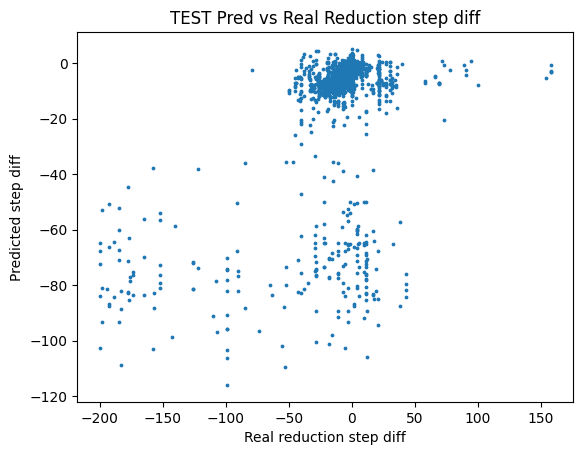

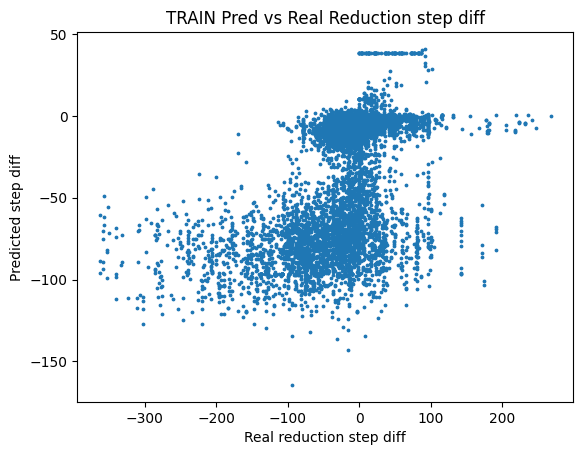

In [38]:
draw_pred_scatter(y_test_pred, y_test_nums, "TEST")
draw_pred_scatter(y_train_pred, y_train_nums, "TRAIN")

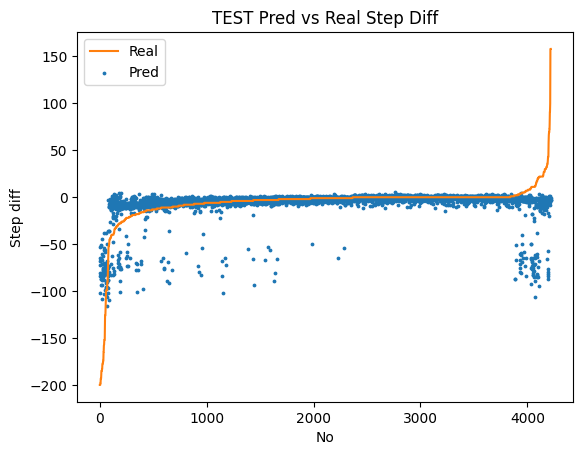

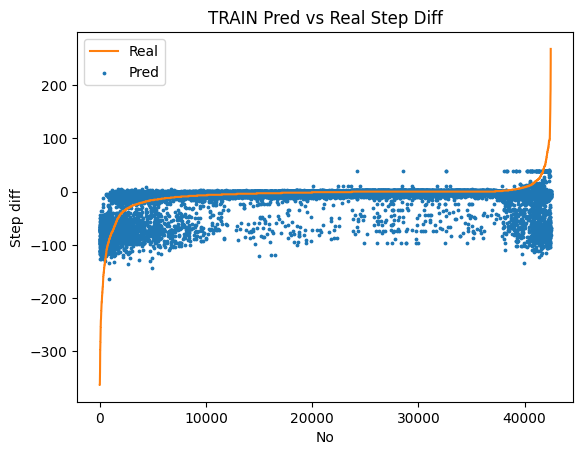

In [51]:
draw_pred_lines_scatter([x_[0] for x_ in y_test_pred], list(y_test_nums), "TEST")
draw_pred_lines_scatter([x_[0] for x_ in y_train_pred], list(y_train_nums), "TRAIN")

In [53]:
rmse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=False)
rmse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=False)
print("TEST {Root Mean Squared Error}:", rmse_test)
print("TRAIN {Root Mean Squared Error}:", rmse_train, "\n")

mse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=True)
mse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=True)
print("TEST {Mean Squared Error}:", mse_test)
print("TRAIN {Mean Squared Error}:", mse_train, "\n")

mae_test = mean_absolute_error(list(y_test_nums), [x_[0] for x_ in y_test_pred])
mae_train = mean_absolute_error(list(y_train_nums), [x_[0] for x_ in y_train_pred])
print("TEST {Mean Absolute Error}:", mae_test)
print("TRAIN {Mean Absolute Error}:", mae_train, "\n")

TEST {Root Mean Squared Error}: 20.603419769844443
TRAIN {Root Mean Squared Error}: 25.81993687951127 

TEST {Mean Squared Error}: 424.5009062124169
TRAIN {Mean Squared Error}: 666.6691404619462 

TEST {Mean Absolute Error}: 8.211192777103157
TRAIN {Mean Absolute Error}: 10.04617047131738 



# Best validation MSE-score model

# load the model
from transformers import TFBertModel

with open("./fine_models/model_diff.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={"TFBertModel": TFBertModel})
model.load_weights('./fine_models/model_diff_best_MSE.h5')

In [ ]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = test_df["diff_steps"]
y_train_nums = train_df["diff_steps"]

In [ ]:
draw_pred_scatter(y_test_pred, y_test_nums, "TEST")
draw_pred_scatter(y_train_pred, y_train_nums, "TRAIN")

In [ ]:
draw_pred_lines_scatter([x_[0] for x_ in y_test_pred], list(y_test_nums), "TEST")
draw_pred_lines_scatter([x_[0] for x_ in y_train_pred], list(y_train_nums), "TRAIN")

In [ ]:
rmse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=False)
rmse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=False)
print("TEST {Root Mean Squared Error}:", rmse_test)
print("TRAIN {Root Mean Squared Error}:", rmse_train, "\n")

mse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=True)
mse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=True)
print("TEST {Mean Squared Error}:", mse_test)
print("TRAIN {Mean Squared Error}:", mse_train, "\n")

mae_test = mean_absolute_error(list(y_test_nums), [x_[0] for x_ in y_test_pred])
mae_train = mean_absolute_error(list(y_train_nums), [x_[0] for x_ in y_train_pred])
print("TEST {Mean Absolute Error}:", mae_test)
print("TRAIN {Mean Absolute Error}:", mae_train, "\n")